In [1]:
# set width = 95%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys
import sklearn
from sklearn.metrics import precision_recall_curve,roc_curve,roc_auc_score

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, **kwargs):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
#     print("Saving figure", fig_id)
    if tight_layout==True:
        plt.tight_layout()
    elif tight_layout==False:
        pass
    else:
        plt.tight_layout(pad=tight_layout)
    plt.savefig(path, format=fig_extension, dpi=resolution,**kwargs)

# function to create histograms from a dataframe
#    attribute: column name to plot (iterates over list). Can contain numeric or boolean data
#    source_cols: one or more boolean columns. If one, splits into False and True categories.
#        otherwise, plots splits to categories: 1st column True, 2nd column True, etc.
#    labels: legend entries for each category
#    colors: edge color for each category
#    bins: histogram bins (list for each attribute)
#    save_suff: plots will be saved as "attribute" + save_suff + ".png"
# todo: allow single categorical series as source_cols
def split_hist(df,attribute,source_cols, labels=None, colors = None, bins=None, save_suff=""):
    # print("histogram for " + attribute.__str__())
    # loop over attributes
    if isinstance(attribute, list):
        for ind_att in range(0,len(attribute)):
            # currently, bins is the only parameter likely to vary by attribute
            if bins != None:
                bins_att = bins[ind_att]
            else:
                bins_att = None
            split_hist(df,attribute[ind_att],source_cols, labels=labels, colors = colors, bins=bins_att, save_suff=save_suff)
        return
    # collect indices for each category
    # cats membership by "True" in source columns
    if isinstance(source_cols, list):
        if len(source_cols)>10:
            raise ValueError("Too many categories to plot")
        if type(source_cols[0]) is np.ndarray:
            idx_list = source_cols
        else:
            idx_list = [df[x] for x in source_cols]
    # for single, boolean column, cats are [False,True]
    else:
        if type(source_cols) is np.ndarray:
            idx_list = [~source_cols,source_cols]
        else:
            idx_list = [~df[source_cols],df[source_cols]]

    # for each category, plot a stair-type histogram
    for ind in range(0,len(idx_list)):
        if colors != None:
            color_arg = {'edgecolor':colors[ind]}
        else:
            color_arg = {'edgecolor':"C{}".format(ind)}
        # boolean attributes work slightly differently
        if df[attribute].dtype==np.dtype('bool'):
            tf_counts = df.loc[idx_list[ind],attribute].value_counts(normalize=True,sort=False)
            # problems if only False or only True
            if len(tf_counts) == 1:
                #tf_counts = pd.Series({tf_counts.index[0]:1.0,not tf_counts.index[0]:0.0})
                tf_counts = pd.Series({False:1.0-tf_counts.index[0],True:0.0+tf_counts.index[0]})
            tf_counts.plot(kind='bar',fill=False, linewidth=10-ind,**color_arg)
            plt.ylim(0,1)
        else:
            df.loc[idx_list[ind],attribute].hist(bins=bins,histtype='step', linewidth=10-ind, density = True,**color_arg)
    plt.legend(labels,loc='upper left')
    plt.title(attribute)
    save_fig(attribute + save_suff)
    plt.show()

def plot_precision_recall_vs_threshold(y_train, y_scores, new_fig = True):
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
    train_TP_portion = sum(y_train)/len(y_train)
    if new_fig:
        plt.figure(figsize=(8, 4))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.axhline(train_TP_portion,label="random")
    plt.legend(loc="upper right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.ylim(0,1)
#     plt.show()

def plot_precision_vs_recall(y_train, y_scores, label=None, new_fig = True):
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
    train_TP_portion = sum(y_train)/len(y_train)
    if new_fig:
        plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, linewidth=2, label=label)
    plt.axhline(train_TP_portion,label="random")
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    if label != None:
        plt.legend()
#     plt.show()
    
def plot_roc_curve(y_train, y_scores, label=None, new_fig = True):
    fpr, tpr, thresholds = roc_curve(y_train, y_scores)
    if new_fig:
        plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)
    if label != None:
        plt.legend()
#     plt.show()

In [3]:
!{sys.executable} -m pip install heatmapz -q
# !pip install heatmapz
from heatmap import heatmap, corrplot

# Get the data

## Attribute Description
From Kaggle
- **GRE** Graduate Record Exam Scores
- **GPA** Grade Point Average
- **Rank** It refers to the prestige of the undergraduate institution.
The variable rank takes on the values 1 through 4. Institutions with a rank of 1 have the highest prestige, while those with a rank of 4 have the lowest.
- **Admit** It is a response variable; admit/don’t admit is a binary variable where 1 indicates that student is admitted and 0 indicates that student is not admitted.
- **SES** SES refers to socioeconomic status: 1 - low, 2 - medium, 3 - high.
- **Gendermale** Gendermale (0, 1) = 0 -> Female, 1 -> Male
- **Race** Race – 1, 2, and 3 represent Hispanic, Asian, and African-American

In [4]:
ADMIT_PATH = PROJECT_ROOT_DIR
def load_admissions_data(admit_path=ADMIT_PATH):
    csv_path = os.path.join(admit_path, "College_admission.csv")
    return pd.read_csv(csv_path)

In [5]:
admissions = load_admissions_data()
admissions.columns = ["admitted","GRE","GPA","socioeconomic_rank","gender_ismale","race_group","ugrad_prestige_rank"]
admissions.head()

,admitted,GRE,GPA,socioeconomic_rank,gender_ismale,race_group,ugrad_prestige_rank
0,0,380,3.61,1,0,3,3
1,1,660,3.67,2,0,2,3
2,1,800,4.00,2,0,2,1
3,1,640,3.19,1,1,2,4
4,0,520,2.93,3,1,2,4


In [6]:
admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   admitted             400 non-null    int64  
 1   GRE                  400 non-null    int64  
 2   GPA                  400 non-null    float64
 3   socioeconomic_rank   400 non-null    int64  
 4   gender_ismale        400 non-null    int64  
 5   race_group           400 non-null    int64  
 6   ugrad_prestige_rank  400 non-null    int64  
dtypes: float64(1), int64(6)
memory usage: 22.0 KB


In [7]:
admissions.describe()

,admitted,GRE,GPA,socioeconomic_rank,gender_ismale,race_group,ugrad_prestige_rank
count,400.000000,400.000000,400.000000,400.000000,400.000,400.000000,400.00000
mean,0.317500,587.700000,3.389900,1.992500,0.475,1.962500,2.48500
std,0.466087,115.516536,0.380567,0.808751,0.500,0.823279,0.94446
min,0.000000,220.000000,2.260000,1.000000,0.000,1.000000,1.00000
25%,0.000000,520.000000,3.130000,1.000000,0.000,1.000000,2.00000
50%,0.000000,580.000000,3.395000,2.000000,0.000,2.000000,2.00000
75%,1.000000,660.000000,3.670000,3.000000,1.000,3.000000,3.00000
max,1.000000,800.000000,4.000000,3.000000,1.000,3.000000,4.00000


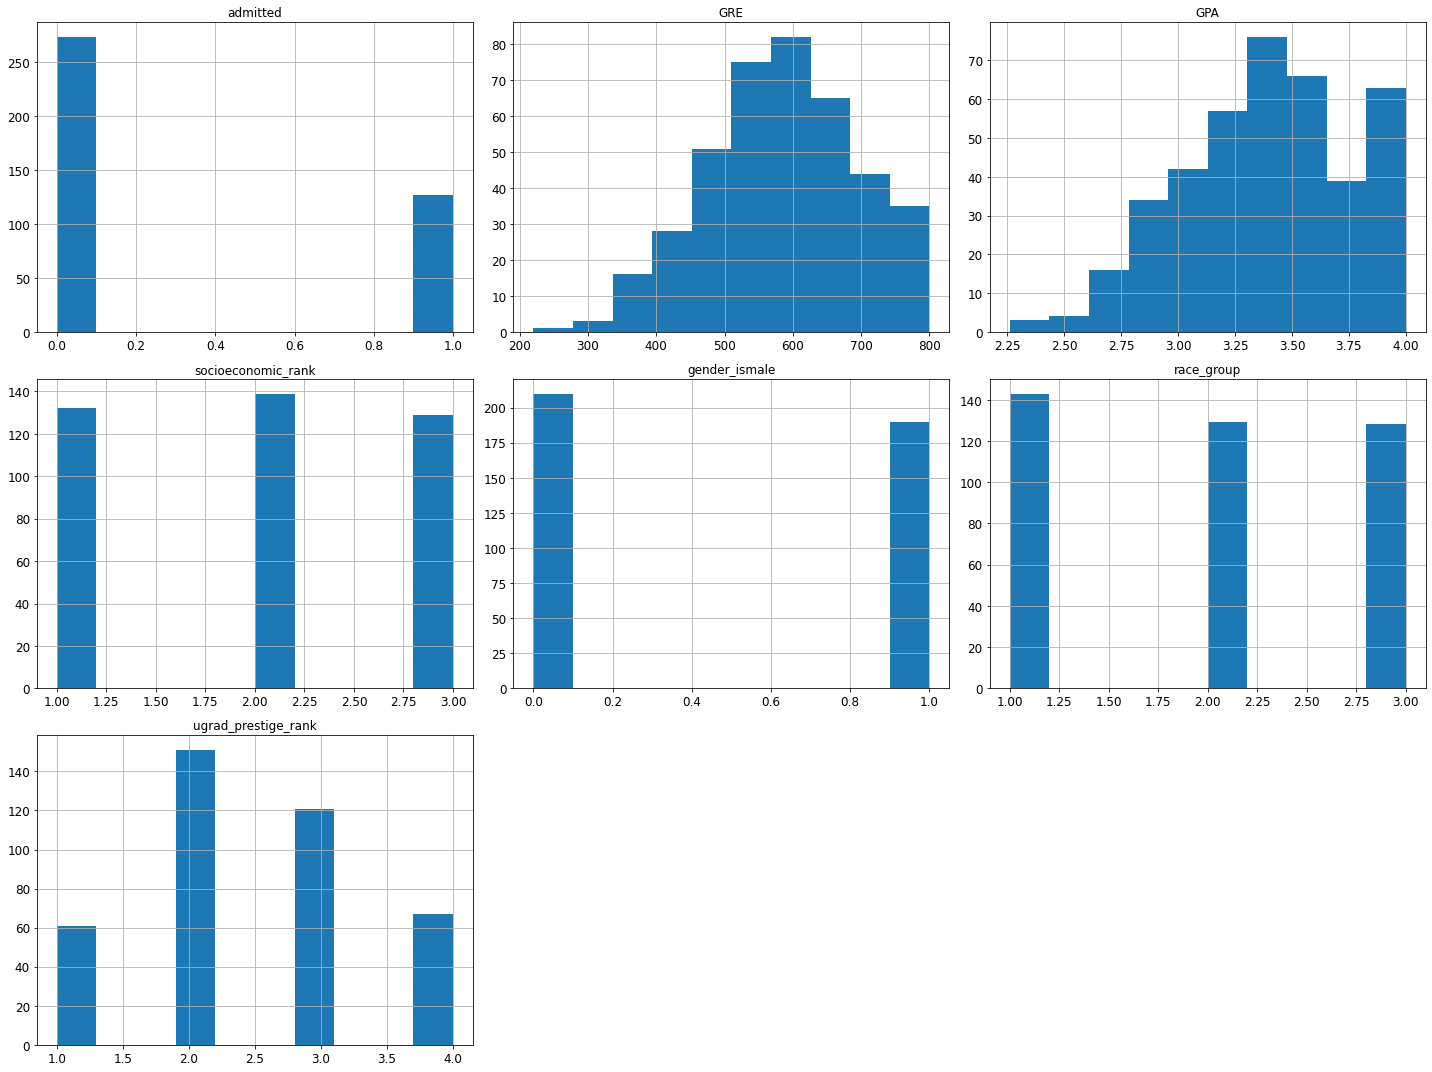

In [8]:
admissions.hist(figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

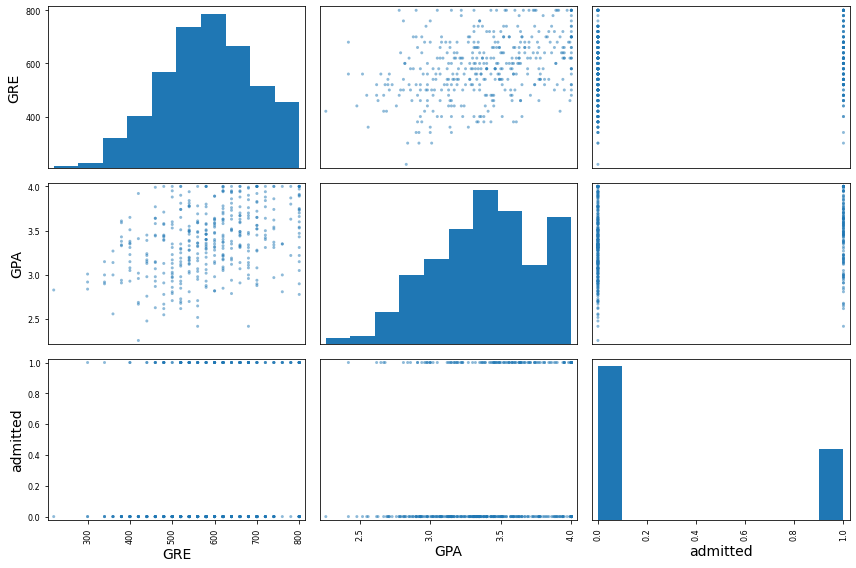

In [9]:
# from pandas.plotting import scatter_matrix
attributes = ["GRE","GPA","admitted"]
pd.plotting.scatter_matrix(admissions[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")
# note: no obvious gaps, but not a great visualization

## Initial notes
- No null data; no clear n/a placeholder (zeros only appear in boolean attributes)
- variable ranges and values appear consistent with descriptions
- most attributes are discrete (e.g., no continuous school ranking)
- significant portion of GPA and GRE scores at max values

In [10]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(admissions, test_size=0.2, random_state=42)

# Deeper data exploration

In [11]:
admissions = train_set.copy()
# flip ugrad_prestige_rank to ascending
admissions["ugrad_prestige_rank"] = 5 - admissions["ugrad_prestige_rank"]
# split race into three columns
admissions["race_isHispanic"] = (admissions["race_group"]==1)
admissions["race_isAsian"] = (admissions["race_group"]==2)
admissions["race_isAA"] = (admissions["race_group"]==3)
# admitted and gender_ismale to boolean for consistency
admissions["gender_ismale"] = (admissions["gender_ismale"] == 1)
admissions["admitted"] = (admissions["admitted"] == 1)
admissions.drop("race_group", axis=1,inplace=True)
admissions.head()

,admitted,GRE,GPA,socioeconomic_rank,gender_ismale,ugrad_prestige_rank,race_isHispanic,race_isAsian,race_isAA
3,True,640,3.19,1,True,1,False,True,False
18,False,800,3.75,1,True,3,False,False,True
202,True,700,4.00,3,False,4,False,False,True
250,False,660,3.31,2,True,1,False,True,False
274,False,520,3.12,3,False,3,True,False,False


In [12]:
# note: gender and race booleans not ordered, but still interpretable
ordered_attributes = admissions.columns
corrs = admissions[ordered_attributes].corr()
# hide distracting diagonals
np.fill_diagonal(corrs.values, np.nan)
# hide non-sensible race correlations (interesting if data allowed multiracial identification)
corrs.iloc[-3:,-3:] = np.nan

,admitted,GRE,GPA,socioeconomic_rank,gender_ismale,ugrad_prestige_rank,race_isHispanic,race_isAsian,race_isAA
admitted,NaN,0.169361,0.190381,-0.061004,-0.065863,0.267459,0.046339,-0.001791,-0.044764
GRE,0.169361,NaN,0.385523,-0.061382,0.041194,0.138766,-0.000951,0.060376,-0.059421
GPA,0.190381,0.385523,NaN,0.012707,-0.017883,0.073112,-0.048164,-0.031756,0.080144
socioeconomic_rank,-0.061004,-0.061382,0.012707,NaN,-0.019130,-0.058854,-0.068181,0.161593,-0.093094
gender_ismale,-0.065863,0.041194,-0.017883,-0.019130,NaN,-0.004509,0.044697,-0.062368,0.017463
ugrad_prestige_rank,0.267459,0.138766,0.073112,-0.058854,-0.004509,NaN,0.073547,-0.002173,-0.071717
race_isHispanic,0.046339,-0.000951,-0.048164,-0.068181,0.044697,0.073547,NaN,NaN,NaN
race_isAsian,-0.001791,0.060376,-0.031756,0.161593,-0.062368,-0.002173,NaN,NaN,NaN
race_isAA,-0.044764,-0.059421,0.080144,-0.093094,0.017463,-0.071717,NaN,NaN,NaN


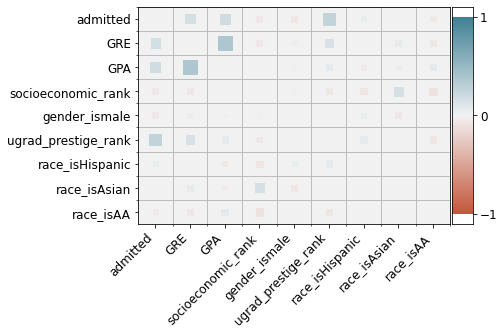

In [13]:
# size+color coded heatmaps from https://github.com/dylan-profiler/heatmaps
corrplot(corrs)
save_fig("correlation_plots",tight_layout=False,bbox_inches='tight')
corrs

## Correlation observations
Note: range of correlations is (-.1 to 0.4)
- admission correlates with common explicit application metrics (GPA, GRE)
- also correlated with prestige of undergrad instition, which is sometimes an explicit metric
- high correlation between GPA and GRE score -- not suprising
- no strong correlations between these four (admission, GRE, GPA, ugrad rank) and other attributes

In [14]:
GRE_bins = np.linspace(200,800,13)
GPA_bins = np.linspace(2.25,4.0,8)

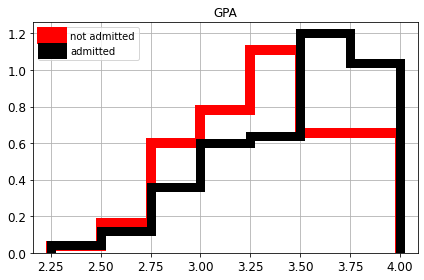

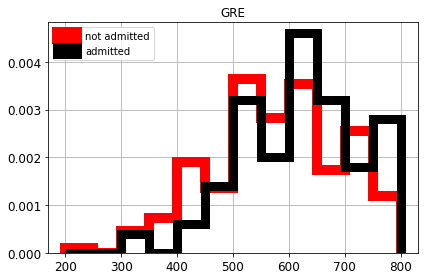

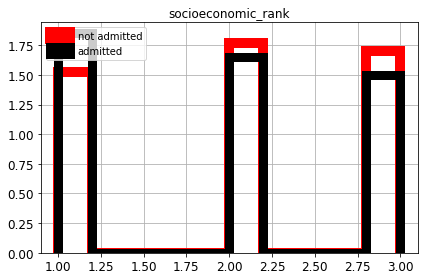

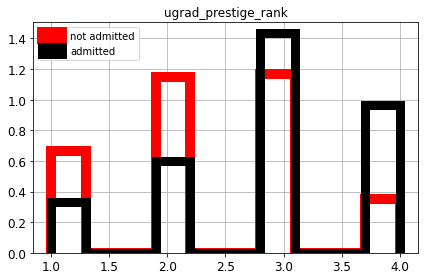

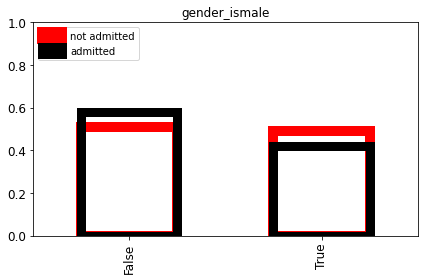

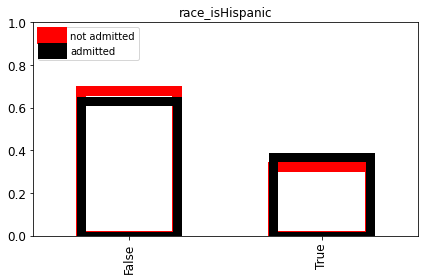

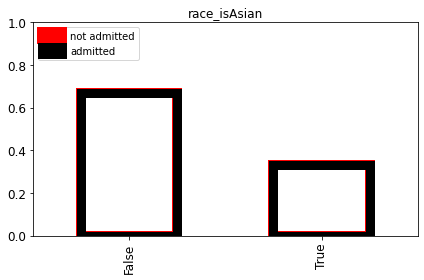

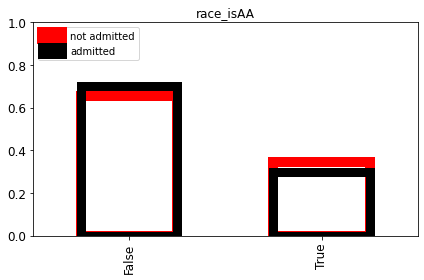

In [15]:
attributes = ["GPA","GRE",'socioeconomic_rank','ugrad_prestige_rank',"gender_ismale", 'race_isHispanic', 'race_isAsian', 'race_isAA']#,'admitted']
bins = [ None for _ in range(len(attributes)) ]
bins[0:1] = [GPA_bins,GRE_bins]
split_hist(df=admissions,attribute=attributes,source_cols='admitted', 
           labels=['not admitted', 'admitted'], colors = ['r','k'], bins=bins, save_suff="_by_admission")

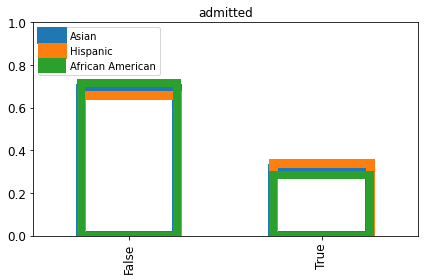

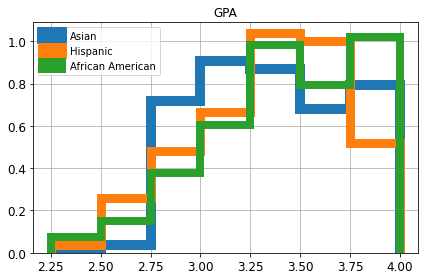

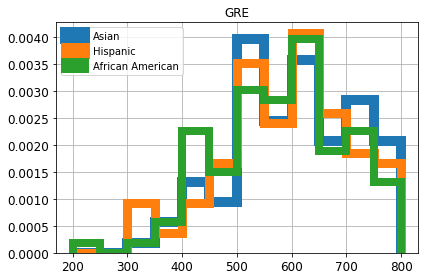

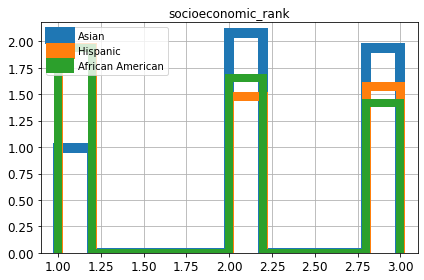

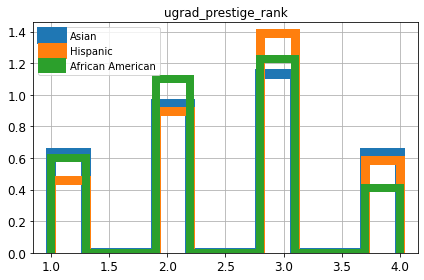

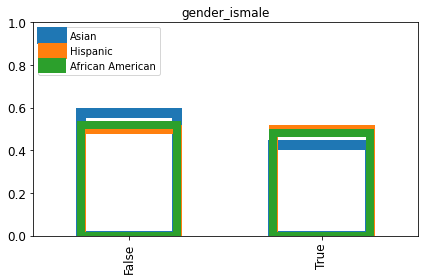

In [16]:
attributes = ['admitted',"GPA","GRE",'socioeconomic_rank','ugrad_prestige_rank',"gender_ismale"]#,'race_isHispanic', 'race_isAsian', 'race_isAA']
bins = [ None for _ in range(len(attributes)) ]
bins[1:2] = [GPA_bins,GRE_bins]
split_hist(df=admissions,attribute=attributes,source_cols=['race_isAsian','race_isHispanic','race_isAA'], labels=['Asian', 'Hispanic', 'African American'], bins=bins, save_suff="_by_race")

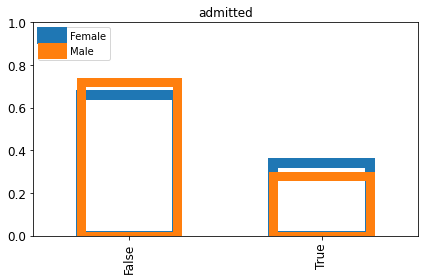

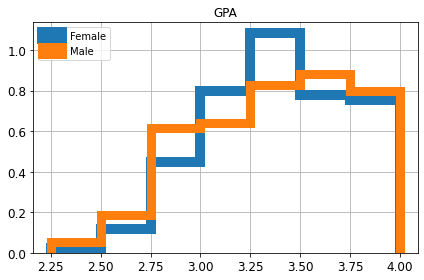

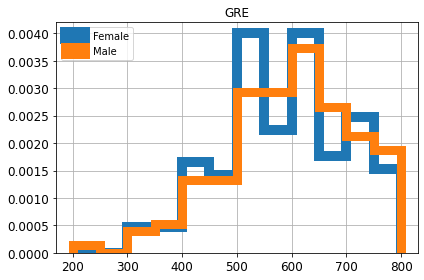

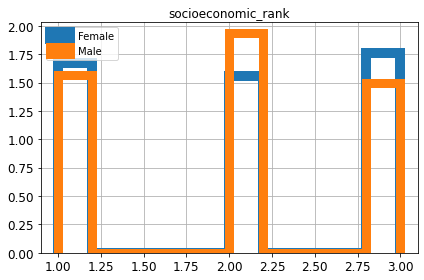

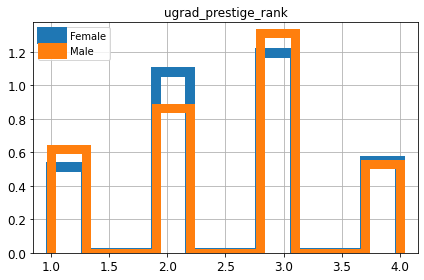

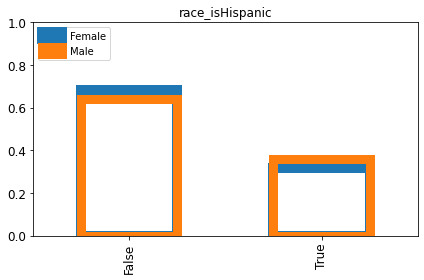

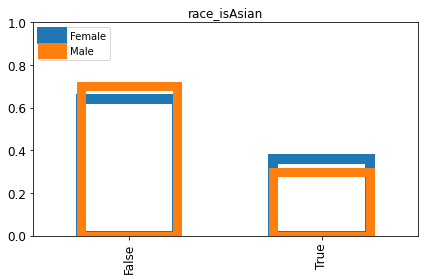

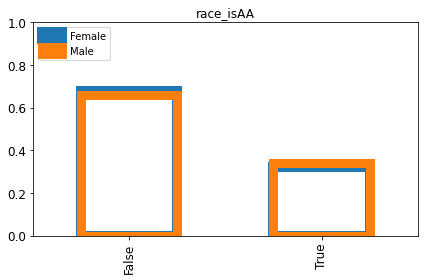

In [17]:
attributes = ['admitted',"GPA","GRE",'socioeconomic_rank','ugrad_prestige_rank', 'race_isHispanic', 'race_isAsian', 'race_isAA']#,"gender_ismale"]
bins = [ None for _ in range(len(attributes)) ]
bins[1:2] = [GPA_bins,GRE_bins]
split_hist(df=admissions,attribute=attributes,source_cols='gender_ismale', 
           labels=['Female', 'Male'], bins=bins, save_suff="_by_gender")

# Classification

In [18]:
x_train = admissions.drop("admitted", axis=1)
y_train = admissions["admitted"]

In [19]:
from sklearn.preprocessing import MinMaxScaler

# create a scaler object
scaler = MinMaxScaler()
# fit and transform the data
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)

## Stochastic Gradient Descent

In [20]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(x_train, y_train)

SGDClassifier(random_state=42)

In [21]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring="accuracy")

array([0.68224299, 0.46728972, 0.38679245])

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(x_train, y_train):
    clone_clf = clone(sgd_clf)
    X_train_folds = x_train.iloc[train_index]
    y_train_folds = y_train.iloc[train_index]
    X_test_fold = x_train.iloc[test_index]
    y_test_fold = y_train.iloc[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.4766355140186916
0.6822429906542056
0.6415094339622641


In [23]:
from sklearn.base import BaseEstimator
class NeverAdmitClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_admit_clf = NeverAdmitClassifier()
cross_val_score(never_admit_clf, x_train, y_train, cv=3, scoring="accuracy")

array([0.73831776, 0.6635514 , 0.66037736])

In [24]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train, cv=3)

In [25]:
from sklearn.metrics import confusion_matrix,plot_confusion_matrix

confusion_matrix(y_train, y_train_pred)
# plot_confusion_matrix(sgd_clf,x_train,y_train)

array([[106, 114],
       [ 42,  58]], dtype=int64)

In [26]:
from sklearn.metrics import precision_score, recall_score,f1_score

print("precision: {:.2f}".format(precision_score(y_train, y_train_pred)))
print("recall: {:.2f}".format(recall_score(y_train, y_train_pred)))
print("F1: {:.2f}".format(f1_score(y_train, y_train_pred)))
y_scores = cross_val_predict(sgd_clf, x_train, y_train, cv=3,
                             method="decision_function")

precision: 0.34
recall: 0.58
F1: 0.43


In [27]:
# precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
# train_TP_portion = sum(y_train)/len(y_train)

AUC: 0.58


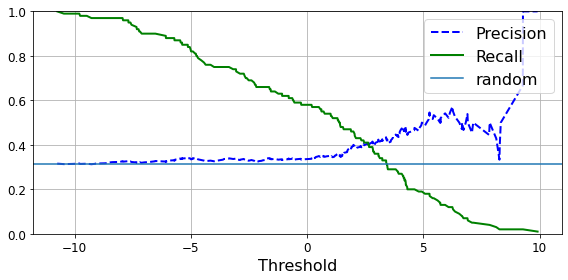

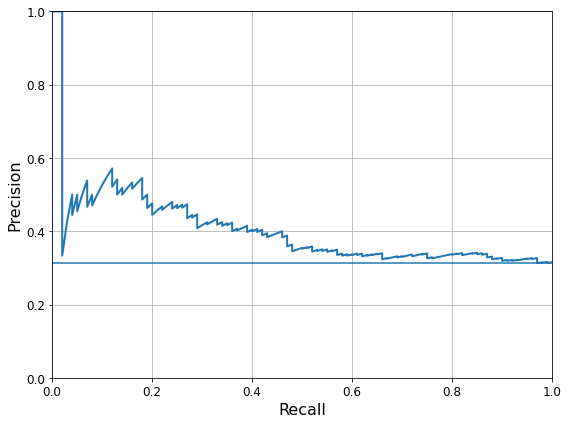

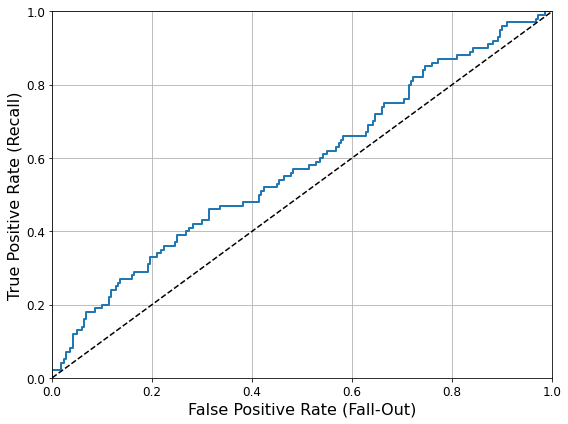

In [28]:
plot_precision_recall_vs_threshold(y_train, y_scores)
save_fig("precision_recall_vs_threshold_" + "SGD")

plot_precision_vs_recall(y_train, y_scores)
save_fig("precision_vs_recall_" + "SGD")

plot_roc_curve(y_train, y_scores)
save_fig("roc_curve_" + "SGD")
print("AUC: {:.2f}".format(roc_auc_score(y_train, y_scores)))

In [29]:
pd.Series(sgd_clf.coef_[0],index=x_train.columns).sort_values().round(2)

socioeconomic_rank    -0.46
gender_ismale          0.00
race_isHispanic        0.92
race_isAsian           0.92
GRE                    1.23
GPA                    1.37
race_isAA              1.83
ugrad_prestige_rank    3.36
dtype: float64

### SGD Summary
- poor performance overall
- generally appears only slightly better than random guess
- no clear "good" threshold value

## Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
y_train_pred_forest = cross_val_predict(forest_clf, x_train, y_train, cv=3)

AUC: 0.63


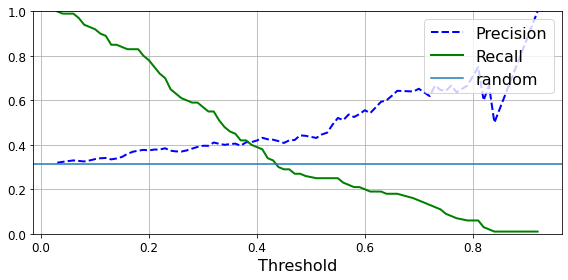

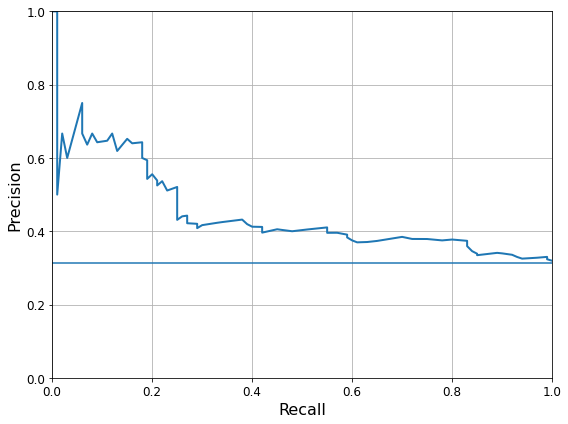

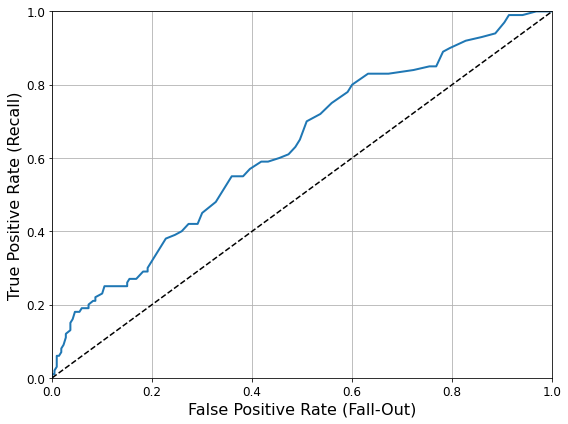

In [31]:
plot_precision_recall_vs_threshold(y_train, y_scores_forest)
save_fig("precision_recall_vs_threshold_" + "Forest")

plot_precision_vs_recall(y_train, y_scores_forest)
save_fig("precision_vs_recall_" + "Forest")

plot_roc_curve(y_train, y_scores_forest)
save_fig("roc_curve_" + "Forest")
print("AUC: {:.2f}".format(roc_auc_score(y_train, y_scores_forest)))

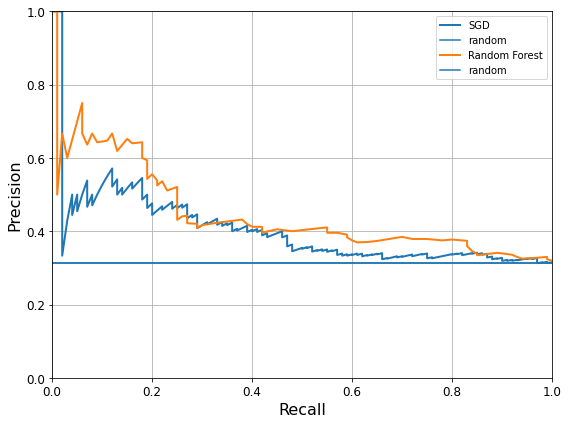

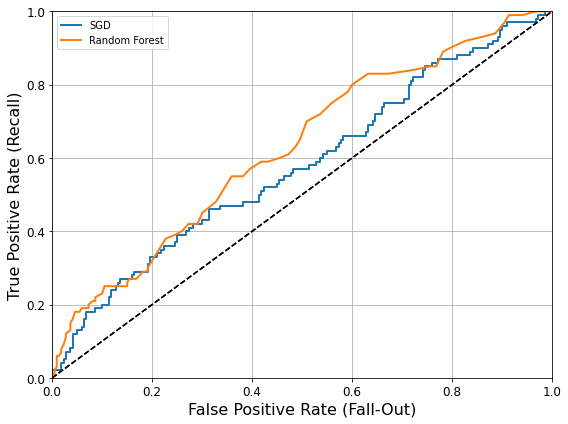

In [32]:
plot_precision_vs_recall(y_train, y_scores,label="SGD")
plot_precision_vs_recall(y_train, y_scores_forest,label="Random Forest",new_fig=False)
save_fig("precision_vs_recall_" + "Both")

plot_roc_curve(y_train, y_scores,label="SGD")
plot_roc_curve(y_train, y_scores_forest,label="Random Forest",new_fig=False)
save_fig("roc_curve_" + "Both")

### Random Forest summary
- slightly better than SGD
- still not good

## Comparing admitted populations by model

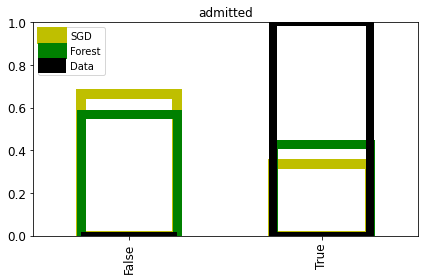

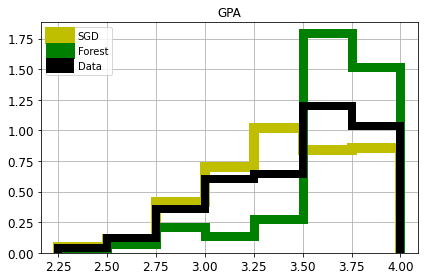

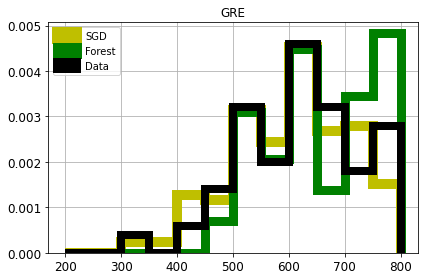

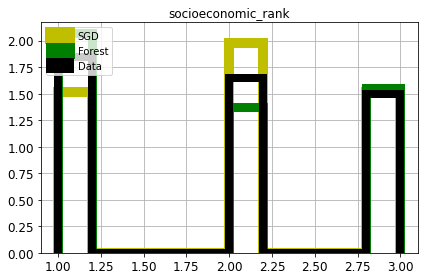

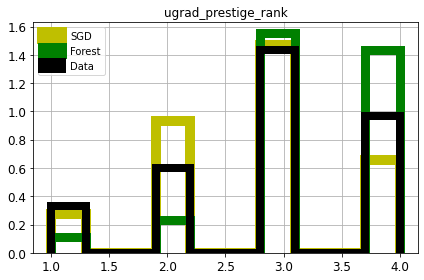

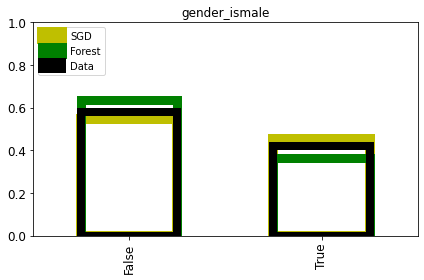

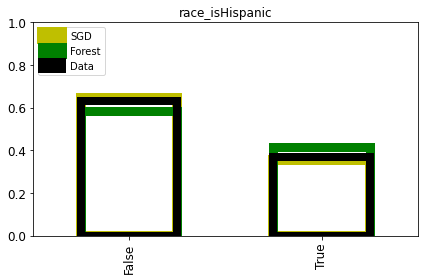

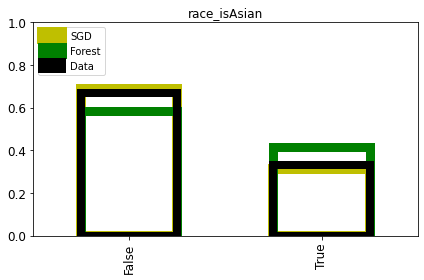

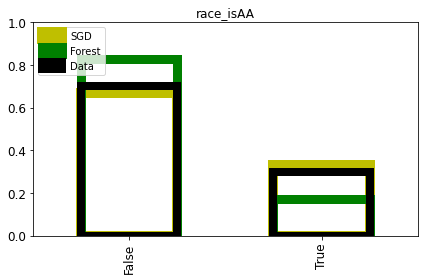

In [33]:
attributes = ['admitted',"GPA","GRE",'socioeconomic_rank','ugrad_prestige_rank',"gender_ismale",'race_isHispanic', 'race_isAsian', 'race_isAA']
split_hist(df=admissions,attribute=attributes,source_cols=[y_train_pred,y_train_pred_forest,admissions['admitted']], 
           labels=['SGD', 'Forest', "Data"], colors = ['y','g','k'], bins=bins, save_suff="_by_classifier")

### Observations:
Both models have poor precision

Random forest more strongly favors <> than reality or SGD:
- GPA > 3.50
- GRE > 700
- high undergrad institution prestige
- Asian and Hispanic students over African-American ones

Stochastic Gradient Descent generally places more preference on middle-ground GPA, ugrad prestige, and socioeconomic rank, but otherwise does not seem to have systemic errors

## Summary and Outlook
Thus far, a classification algorithm with satisfactory performance has not been found. In addition to poor performance, the random forest model shows worrisome preferences which may reinforce existing disparities if used improperly.